**Upotreba procesa koji simuliraju po jednu ćeliju i sinhronizacijom redovima za poruke** 
<p> Svaki proces simulira rad jedne ćelije u sistemu. Stanje svake ćelije se čuva unutar ćelije (rad sistema se ne oslanja na deljenu matricu stanja). Ćelije podatke o svojem stanju razmenjuju putem reda za poruke. Za potrebe analize rada implementirati poseban servis (dodatni proces) kojem sve ćelije javljaju novo stanje prilikom promene (pri čemu poruke sadrže koordinate ćelije, broj iteracije i novo stanje). Servis treba da rekonstruiše i sačuva (ili vrati u glavni program) niz matrica stanja.



**Explicitly pass resources to child processes**

<p>On Unix using the fork start method, a child process can make use of a shared resource created in a parent process using a global resource. However, it is better to pass the object as an argument to the constructor for the child process.

Apart from making the code (potentially) compatible with Windows and the other start methods this also ensures that as long as the child process is still alive the object will not be garbage collected in the parent process. This might be important if some resource is freed when the object is garbage collected in the parent process.

**Avoid shared state**

As far as possible one should try to avoid shifting large amounts of data between processes.

It is probably best to stick to using **queues or pipes** for communication between processes rather than using the lower level synchronization primitives.

In [1]:
import sys
import numpy as np
import multiprocessing
import copy

def control (n, steps, cell_updated, next_iteration, conn):        # funkcija za kontrolor proces
    states = np.zeros(shape = (steps, n, n), dtype = np.int8)
    for _ in range(steps):
        for i in range (n**2):                                                      # ceka poruku sa azuriranim stanjem svake celije koja je spremna za sledecu iteraciju
            msg = cell_updated.get()                                                  # get - blokirajuci poziv, ova petlja ce se zavrsiti tek kada se sve celije upisu u queue
            states[msg[0]][msg[1]][msg[2]] = msg[3]                                   # kada primi poruku azurira odredjeno polje u listi stanja
        for i in range (n**2):
            next_iteration[i].put(1)                                                  # kada su sve azurirane, javlja svakoj celiji da predje u sledecu iteraciju
    conn.send(states)                                                             # na kraju putem pipe-a vraca listu stanja u main proces
      

def live (x, y, state, n, steps, queues, cell_updated, next_iteration):    # sve promenljive saljemo kao argumente - preporuka sa interneta
    for step in range(steps):
        alive = 0     
        cid = x*n+y
        for move in range (8):                                  
            x1 = (x + xx[move]) % n
            y1 = (y + yy[move]) % n                                 
            neighbor_id = x1*n + y1  
            queues[neighbor_id].put(state)                                            # u queue svakog suseda celija upisuje svoje stanje
        for i in range (8):                                    
            alive += queues[cid].get()                                                # zatim cita stanja suseda iz svog queue-a (sabira zive)
        if (alive < 2 or alive > 3):                           
            state = 0                                             
        elif alive == 3:
            state = 1
        elif alive == 2 and state == 1:
            state = 1
        cell_updated.put((step, x, y, state))                   # salje kroz queue kontroler threadu poruku sa novim stanjem i spremna je za sledecu iteraciju
        next_iteration[cid].get()                               # get - blokirajuci poziv, ceka signal od kontrolera da sme da zapocne novu iteraciju


if __name__ == "__main__":
    n = 20
    steps = 20
    start_state = (np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)  

    queues = [multiprocessing.JoinableQueue(8) for _ in range(n**2)]              # redovi svakog procesa za stanja susednih procesa        
    cell_updated = multiprocessing.JoinableQueue(n**2)                            # red kojim celije javljaju nova stanja kontroler threadu
    next_iteration = [multiprocessing.JoinableQueue(1) for _ in range(n**2)]    # redovi za signal svakoj celiji da zapocne sledecu iteraciju
    conn1, conn2 = multiprocessing.Pipe()                                         # pipe za komunikaciju glavnog procesa i kontrolor procesa  (za vracanje stanja)

    xx = [1, 1, 1, -1, -1, -1, 0, 0]                                
    yy = [1, -1, 0, 1, -1, 0, 1, -1]

    controller = multiprocessing.Process(target = control, args = (n, steps, cell_updated, next_iteration, conn1))
    processes = []
    for i in range(n**2):
        x = i//n
        y = i%n
        processes.append(multiprocessing.Process(target = live, args=(x, y, start_state[x][y], n, steps, queues, cell_updated, next_iteration)))

    controller.start()  
    for p in processes:
        p.start()

    for p in processes:
        p.join()
    controller.join()

    states = conn2.recv()                                                         # uzimanje liste stanja preko pipe-a u glavni proces
    conn1.close()
    conn2.close()


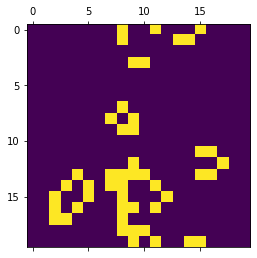

In [2]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(states);
HTML(anim.to_html5_video())